In [1]:
import sys
import os
import gc
# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import torch

from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
from Cifar10HelperFunctions.GetStandardData import class_wise_preprocessed_cifar10
train_datas, test_datas, test_data_for_repository = class_wise_preprocessed_cifar10()

Files already downloaded and verified
Files already downloaded and verified


Data format: 
--------------------------------
type(train_datas[i].data[0]) -> <class 'torch.Tensor'>
train_datas[i].data[0].dtype -> torch.float32

type(train_datas[i].targets) -> <class 'torch.Tensor'>
train_datas[i].targets.dtype -> torch.int64


Access Data by indexing
--------------------------------
train_datas[i][0] -> (torch.Size([3, 32, 32]), torch.Size([]))


max and min values of train_datas[i].data:
--------------------------------
	[(tensor(0.), tensor(1.))]





In [3]:
torch.manual_seed(42)

repository_size = 10
# NUM_DIMENSIONS = 28*28
NUM_EPOCHS = 100
label_for_zero = 0
BATCH_SIZE = 16
learning_rate = 0.001


n_train_zeros = 100_000
n_test_zeros = 1_000

device="cuda" if torch.cuda.is_available() else "cpu"



Class-0 training ...
Training...(epochs: 100)
Epoch: 0
----------------
Epoch: 1
----------------
Epoch: 2
----------------
Epoch: 3
----------------
Epoch: 4
----------------
Epoch: 5
----------------
Epoch: 6
----------------
Epoch: 7
----------------
Epoch: 8
----------------
Epoch: 9
----------------
Epoch: 10
----------------
Epoch: 11
----------------
Epoch: 12
----------------
Epoch: 13
----------------
Epoch: 14
----------------
Epoch: 15
----------------
Epoch: 16
----------------
Epoch: 17
----------------
Epoch: 18
----------------
Epoch: 19
----------------
Epoch: 20
----------------
Epoch: 21
----------------
Epoch: 22
----------------
Epoch: 23
----------------
Epoch: 24
----------------
Epoch: 25
----------------
Epoch: 26
----------------
Epoch: 27
----------------
Epoch: 28
----------------
Epoch: 29
----------------
Epoch: 30
----------------
Epoch: 31
----------------
Epoch: 32
----------------
Epoch: 33
----------------
Epoch: 34
----------------
Epoch: 35
---------

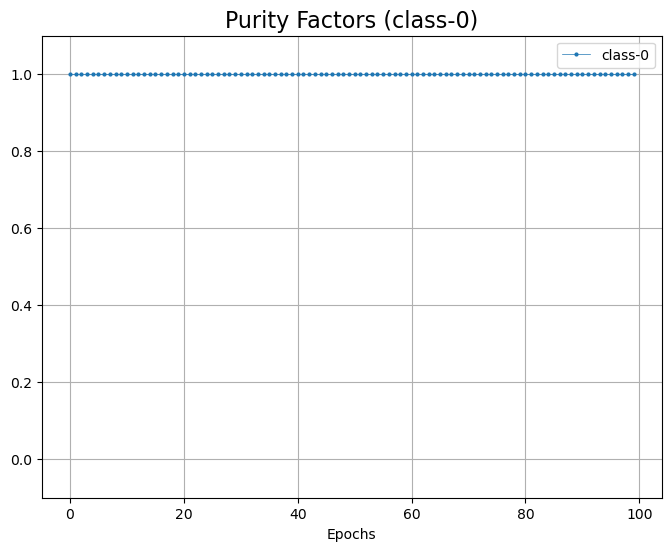

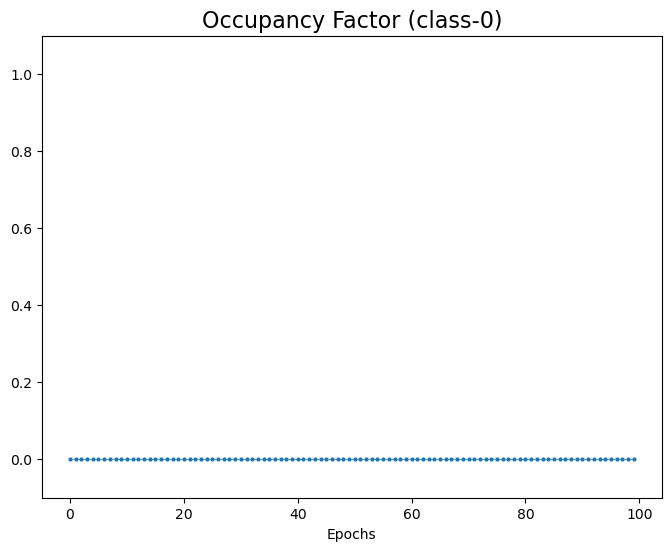

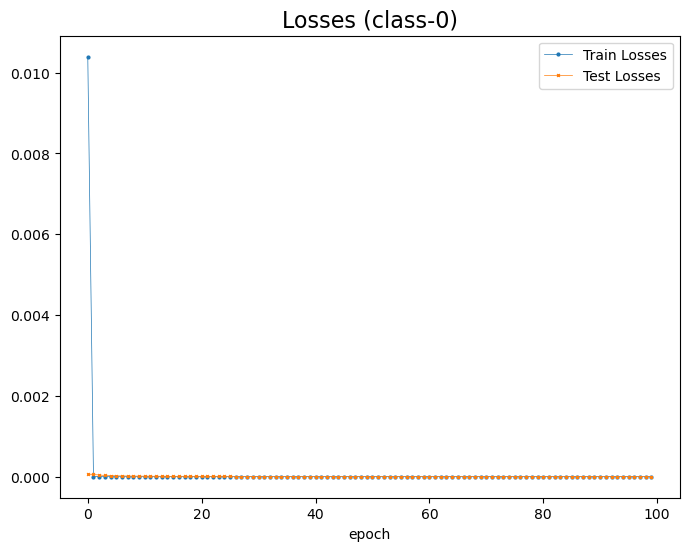

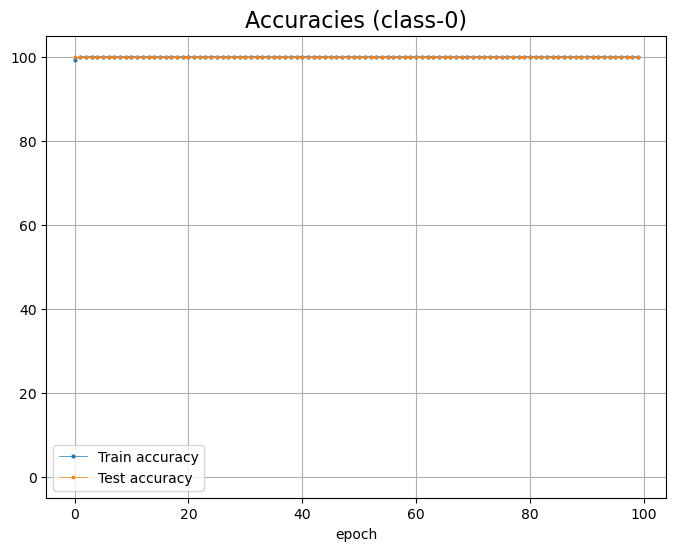

Class-1 training ...
Training...(epochs: 100)
Epoch: 0
----------------
Epoch: 1
----------------
Epoch: 2
----------------
Epoch: 3
----------------
Epoch: 4
----------------
Epoch: 5
----------------
Epoch: 6
----------------
Epoch: 7
----------------
Epoch: 8
----------------
Epoch: 9
----------------
Epoch: 10
----------------
Epoch: 11
----------------
Epoch: 12
----------------
Epoch: 13
----------------
Epoch: 14
----------------
Epoch: 15
----------------
Epoch: 16
----------------
Epoch: 17
----------------
Epoch: 18
----------------
Epoch: 19
----------------
Epoch: 20
----------------
Epoch: 21
----------------
Epoch: 22
----------------
Epoch: 23
----------------
Epoch: 24
----------------
Epoch: 25
----------------
Epoch: 26
----------------
Epoch: 27
----------------
Epoch: 28
----------------
Epoch: 29
----------------
Epoch: 30
----------------
Epoch: 31
----------------
Epoch: 32
----------------
Epoch: 33
----------------
Epoch: 34
----------------
Epoch: 35
---------

In [ ]:
from ZeroHelperFunctions.DataLoadersForZero import DataLoadersForZero
from Networks.networks import ClassWiseVGGNet
from ZeroHelperFunctions.zeroTrainer import ZeroTrainer

from torch import nn

from ZeroHelperFunctions import plots
from ZeroHelperFunctions.Curiosity import CuriosityRover

mnist_rover = CuriosityRover(device=device)

for cl in range(repository_size):
    print(f"Class-{cl} training ...")
    dl = DataLoadersForZero(train_data=train_datas[cl],
                            test_data=test_datas[cl],
                            image_shape=(3, 32, 32))
    dl.make_dataloaders(batch_size=BATCH_SIZE,
                        n_train_zeros=n_train_zeros,
                        n_test_zeros=n_test_zeros,
                        label_for_zero=label_for_zero)
    # dl.show_border_images_of_combined_data(6000)
    dl.generate_zero_class_dataloader(10000, BATCH_SIZE)
    zero_model = ClassWiseVGGNet(out_nodes=2)
    zero_trainer = ZeroTrainer(model=zero_model,
                               number_of_non_zero_classes=1,
                               train_dl=dl.train0_dataloader,
                               test_dl=dl.test_dataloader,
                               purity_fact_dl=dl.test0_dataloader,
                               zero_dl=dl.zero_dataloader,
                               loss_fn=nn.CrossEntropyLoss(),
                               optimizer=torch.optim.SGD(params=zero_model.parameters(), lr=learning_rate),
                               label_of_zero_class=label_for_zero,
                               device=device)
    zero_trainer.train(epochs=NUM_EPOCHS)
    plots.plot_pf(zero_trainer.purities, title=f"class-{cl}")
    plots.plot_of(zero_trainer.occupancy, title=f"class-{cl}")
    plots.plot_train_test_losses(zero_trainer.train_loss,
                                 zero_trainer.test_loss, title=f"class-{cl}")
    plots.plot_train_test_accs(zero_trainer.train_acc,
                               zero_trainer.test_acc, title=f"class-{cl}")
    mnist_rover.add_model_for_an_anomaly(zero_model, f"MNIST - {cl}")

In [5]:
from torch.utils.data import DataLoader

test_dataloader_for_repository = DataLoader(test_data_for_repository,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)

In [6]:
from ZeroHelperFunctions.Mismatches import Mismatches
mismatch = Mismatches(test_dataloader_for_repository, mnist_rover)

In [7]:
mismatch.test_acc

In [8]:
from ZeroHelperFunctions.zero_class_images_generator_mnist import ZeroClassDataset

In [9]:
zero_vector_data = ZeroClassDataset(num_samples=10, image_shape=(3, 32, 32), label=label_for_zero)

In [10]:
zero_vector_data.data[0].shape

In [11]:
from ZeroHelperFunctions.show_image import show_one_color_image
show_one_color_image(zero_vector_data.data[0])

In [12]:
xk = zero_vector_data.data[0]

def generate(starting_noise, class_name, step_size, iterations=100, print_freq=10):
    xk = starting_noise
    xk = xk.clone().detach().requires_grad_(True) 
    xk.shape, xk.requires_grad
    zero_model = mnist_rover.learned_anomaly_models[class_name]
    zero_model.eval()
    logits = zero_model(xk.to("cuda" if torch.cuda.is_available() else "cpu"))
    target_logit = logits[:, 1]
    target_logit
    target_logit.backward()
    gradients = xk.grad
    xk = xk + gradients * step_size
    xk[0].shape
    print("wtf")
    show_one_color_image(xk[0].detach().cpu().numpy())
    for i in range(iterations):
        xk = xk.clone().detach().requires_grad_(True) 
        xk.shape, xk.requires_grad
        zero_model.eval()
        logits = zero_model(xk.to("cuda" if torch.cuda.is_available() else "cpu"))
        target_logit = logits[:, 1]
        target_logit
        target_logit.backward()
        gradients = xk.grad
        xk = xk + gradients * step_size
        xk[0].shape
        if i % print_freq == 0:
            print("iteration number: ", i)
            show_one_color_image(xk[0].detach().cpu().numpy())

In [13]:
generate(starting_noise=zero_vector_data.data[0].unsqueeze(0), 
         class_name=0, 
         step_size=0.01, 
         iterations=3001,
         print_freq=500)